# **Proyecto final: Usando computación evolutiva para encontrar localizaciones optimas de una cadena de supermercados**

## **1) Algoritmo genético mono-objetivo**

**a) Importando las librerias necesarias**

In [2]:
pip install git+https://github.com/python-visualization/folium

  Cloning https://github.com/python-visualization/folium to /tmp/pip-req-build-r8dpxcao
  Running command git clone -q https://github.com/python-visualization/folium /tmp/pip-req-build-r8dpxcao
  Created wheel for folium: filename=folium-0.10.0+4.ga1e3686-py2.py3-none-any.whl size=91404 sha256=6522960e8e0ba6e33be80a4fd90c5997ccc9e13be142145f4ae431833289cf17
  Stored in directory: /tmp/pip-ephem-wheel-cache-0_nxen_m/wheels/1e/e1/75/ecbc91fd5dd5d90befb0b533bf7492d38acffa033310731862
Successfully built folium
Note: you may need to restart the kernel to use updated packages.


In [99]:
import pandas as pd
import math
import sys
import time
import numpy as np
from random import shuffle, random, sample, randint, randrange, uniform
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from datetime import timedelta
import datetime
from folium.plugins import TimestampedGeoJson
import numpy as np
from sklearn.preprocessing import MinMaxScaler,MaxAbsScaler

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd gdrive/My\ Drive/'Colab Notebooks'/'Algoritmos Bioinspirados'/'Proyecto Final/'
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/Algoritmos Bioinspirados/Proyecto Final
Candidatos_supermercados.xlsx  OptimizacionMarket.ipynb
earthHTML.html		       proyectoFinal.ipynb
mapTimer.html		       proyectoFinal-previousVersion.ipynb
monoSolution.html


**b) Leyendo la información proporcionada**

In [194]:
dataset=pd.read_excel('../UbicacionSupermercados/Candidatos_supermercados.xlsx')
dataset.head()

,ID,Descripcion,Latitud,Longitud,Poblacion500m
0,Punto 1,Esq. Benavides con Nicolas Dueñas,-12.04861,-77.06496,16500
1,Ponto 2,Sta Bernardita con Republica de Venezuela,-12.05956,-77.07583,18000
2,Ponto 3,Santa Susana con Santa Gertrudis,-12.06524,-77.07334,17000
3,Ponto 4,Belizario Sosa Pelaez,-12.05998,-77.06300,15000
4,Ponto 5,Esq. Aurelio Garcia y Miranono Arredondo,-12.05541,-77.07497,17100


**c) Cálculo de las distancias entre cada punto**

Función para el cálculo de las distancias entre dos puntos teniendo la latitud y longitud de las coordenadas

In [195]:
lista_total_distancias={}
radio_tierra=6378 #radio ecuatorial
def getDistances(dataset):
    """Función para el cálculo de las distancias entre todos los puntos teniendo la latitud y longitud de las coordenadas.
    
    Para el cálculo de las distancias entre los puntos se hace uso de Haversine Formula
    Parámetros:
                -dataset: Dataset del tipo dataFrame pandas
                
    Retorna: Un diccionario de la forma {(punto1,punto2):distancia}
    """
    valores=dataset[['Latitud','Longitud']].values
    for i in range(len(valores)):
        for j in range(i+1,len(valores)):
            dif_lat=valores[j][0] - valores[i][0] #Hallamos la diferencia de latitud
            dif_lon=valores[j][1] - valores[i][1] #Hallamos la diferencia de longitud
            a=pow(math.sin(dif_lat/2),2)+(math.cos(valores[i][0])*(math.cos(valores[j][0])))*pow(math.sin(dif_lon/2),2)
            c=2*math.asin(min(1,math.sqrt(a)))
            lista_total_distancias[(i,j)]=radio_tierra * c #*1000 #multiplicar por mil para obtener en metros

In [196]:
getDistances(dataset)

In [197]:
lista_total_distancias[(0,1)]

92.35295446475958

**Escalamiento de los valores(poblacion y distancia) que serán sumados para hallar el fitness**

Juntamos todos los datos

In [198]:
datos_juntos=list(lista_total_distancias.values())+list(dataset.Poblacion500m.values)
datos_juntos=np.array(datos_juntos).reshape(-1,1)

Escalamos

In [199]:
min_max_scaler=MaxAbsScaler()
datos_juntos_escalados=min_max_scaler.fit_transform(datos_juntos)
datos_juntos_escalados

array([[0.00461765],
       [0.00579378],
       [0.0036666 ],
       ...,
       [0.9       ],
       [0.925     ],
       [1.        ]])

Separamos distancia de poblacion

In [200]:
datos_distancia_escalada=datos_juntos_escalados[:1770]
len(datos_distancia_escalada)

1770

In [201]:
datos_poblacion_escalada=datos_juntos_escalados[1770:]
len(datos_poblacion_escalada)

60

Almacenamiento de las distancias escaladas

In [202]:
keys_lista=[i for i in lista_total_distancias] #Almacenamos los keys del diccionario de las distancias
lista_total_distancias_escalado={keys_lista[i]:datos_distancia_escalada[i][0] for i in range(len(keys_lista))} #Creamos un nuevo dic con las distancias escaladas
lista_total_distancias_escalado[(0,1)]

0.004617647723237979

Almacenamiento de la poblacion escalada

In [203]:
dataset['poblacion_escalado']=datos_poblacion_escalada
dataset.head()

,ID,Descripcion,Latitud,Longitud,Poblacion500m,poblacion_escalado
0,Punto 1,Esq. Benavides con Nicolas Dueñas,-12.04861,-77.06496,16500,0.825
1,Ponto 2,Sta Bernardita con Republica de Venezuela,-12.05956,-77.07583,18000,0.900
2,Ponto 3,Santa Susana con Santa Gertrudis,-12.06524,-77.07334,17000,0.850
3,Ponto 4,Belizario Sosa Pelaez,-12.05998,-77.06300,15000,0.750
4,Ponto 5,Esq. Aurelio Garcia y Miranono Arredondo,-12.05541,-77.07497,17100,0.855


**d) Definición del objeto Market para el problema**

Un objeto de la clase Market almacena las instancias del dataframe

In [204]:
class Market(object):
    def __init__(self,ID,descr,pob,latitud,longitud):
        self.id=ID
        self.descr=descr
        self.pob=pob
        self.lat=latitud
        self.lon=longitud

**e) Definición de la estructura de un individuo en el AG con sus operadores genéticos**

In [205]:
class Individual:
    """ Implementa el individuo del AG. Un individuo tiene un cromosoma que es una lista de num_markets elementos (genes),
       cada gen i puede asumir dos posibles alelos: 0 o 1 (no incluir/incluir en la solución el market i del pool) """

    def __init__(self, chromosome,maxMark=10):  # el constructor recibe un cromosoma
        self.chromosome = chromosome[:]  
        self.fitness = -1  # -1 indica que el individuo no ha sido evaluado
        self.maxMark=maxMark #Cantidad Máxima de markets que desea obtener en la solución

    def crossover_onepoint(self, other):
        "Retorna dos nuevos individuos del cruzamiento de un punto entre individuos self y other "
        c = randrange(len(self.chromosome))
        ind1 = Individual(self.chromosome[:c] + other.chromosome[c:],self.maxMark)
        ind2 = Individual(other.chromosome[:c] + self.chromosome[c:],self.maxMark)
        ind1,ind2=self.__verify([ind1,ind2])
        return [ind1, ind2]   
    
    def crossover_uniform(self, other):
        chromosome1 = []
        chromosome2 = []
        "Retorna dos nuevos individuos del cruzamiento uniforme entre self y other "
        for i in range(len(self.chromosome)):
            if uniform(0, 1) < 0.5:
                chromosome1.append(self.chromosome[i])
                chromosome2.append(other.chromosome[i])
            else:
                chromosome1.append(other.chromosome[i])
                chromosome2.append(self.chromosome[i])
        ind1 = Individual(chromosome1,self.maxMark)
        ind2 = Individual(chromosome2,self.maxMark)
        ind1,ind2=self.__verify([ind1,ind2])
        return [ind1, ind2] 
    
    
    def mutation_flip(self):
        "Cambia aleatoriamente el alelo de un gen. Se tiene en consideración la cantidad máxima de markets que debe contar una posible solución."
        new_chromosome = deepcopy(self.chromosome)
        mutGene = randrange(0,len(new_chromosome))   # escoge un gen para mutar
        if new_chromosome[mutGene] == 0:
            #Cambiaremos un cero a un uno, por lo que habrá un uno mas, por lo que se deberá cambiar otro uno a cero
            index_unos=[i for i in range(len(new_chromosome)) if new_chromosome[i] == 1]
            index_uno=sample(index_unos,1) #Obtenemos un index de todos los unos para cambiarlo a cero
            new_chromosome[mutGene] = 1 #Cambiamos a uno un cero
            new_chromosome[index_uno[0]]=0 #Cambiamos a cero un uno
        else:
            index_ceros=[i for i in range(len(new_chromosome)) if new_chromosome[i] == 0]
            index_cero=sample(index_ceros,1) #Obtenemos un index de todos los unos para cambiarlo a cero
            new_chromosome[mutGene] = 0 #Compensamos
            new_chromosome[index_cero[0]]=1 #Cambiamos a uno un cero
            
        return Individual(new_chromosome,self.maxMark)
        
    
    def __verify(self,individuos):
        """Funcion para forzar que existan la cantidad máxima de markets(unos) dentro del cromosoma.
        """
        resultado=[]
        for ind in individuos:
            cant_unos=ind.chromosome.count(1)
            index_unos=[i for i in range(len(ind.chromosome)) if ind.chromosome[i] == 1] #Obtenemos los index de los unos dentro del cromosoma
            if cant_unos >self.maxMark: #Verificando si el individuo tiene la cantidad maxima de markets(unos) aceptables 
                index_unos2chg=sample(index_unos,cant_unos - self.maxMark)# Obtenemos los index que cambiaremos a cero porque se pasó del máximo
                for index in index_unos2chg:
                    ind.chromosome[index]=0
            elif cant_unos < self.maxMark: #Si el individuo tiene menos de la cantidad máxima 
                index_unos2chg=set(range(len(ind.chromosome))) - set(index_unos) #Quitamos los index en los cuales se encuentran los unos
                random_index=sample(index_unos2chg,self.maxMark - cant_unos) #Generamos index aletorios para completar a la cantidad máxima
                for index in random_index:
                    ind.chromosome[index]=1
            resultado.append(ind)
        return resultado


**f) Función para obtener el fitness del cromosoma**

Haciendo uso del diccionario hallado previamente.

In [206]:
def get_fitness_lista(chromosome, markets):
    """Retorna el fitness del cromosoma pasado. Fitness es el valor total de los markets incluidos en el cromosoma
        """
    fitness=0
    markets_elegidos=[]
    sum_pob=0
    sum_dist=0
    for i in range(len(markets)):
        if chromosome[i] == 1:  # si el market i esta incluido en el cromosoma, acumula su poblacion y distancia
            sum_pob += markets[i].pob
            markets_elegidos.append(i)
            
    for j in markets_elegidos:
        for k in markets_elegidos[j+1:]:
            sum_dist=sum_dist+lista_total_distancias[(j,k)] # Hacemos uso del diccionario calculado previamente, sin escalamiento
            #sum_dist=sum_dist+lista_total_distancias_escalado[(j,k)]#diccionario con las distancias escaladas
    
    return [sum_pob,sum_dist] #Se enviará de esta manera y se obtendrá las sumas por separado para la experimentación y registro de estos experimentos

Calculando las distancias en cada instante

In [207]:
def get_fitness(chromosome, markets):
    """Retorna el fitness del cromosoma pasado. Fitness es el valor total de los markets incluidos en el cromosoma
        """
    fitness = 0 # initialize fitness to 0
    lista_distancias=[]
    sum_pob=0
    sum_dist=0
    for i in range(len(markets)):
        if chromosome[i] == 1:  # si el market i esta incluido en el cromosoma, acumula su poblacion y distancia
            sum_pob += markets[i].pob
            lista_distancias.append((markets[i].lat,markets[i].lon))
            
    radio_tierra=6378 #radio ecuatorial
    for i in range(len(lista_distancias)):
        for j in lista_distancias[i+1:]:
            dif_lat=j[0] - lista_distancias[i][0] #Hallamos la diferencia de latitud
            dif_lon=j[1] - lista_distancias[i][1] #Hallamos la diferencia de longitud
            a=pow(math.sin(dif_lat/2),2)+(math.cos(lista_distancias[i][0])*(math.cos(j[0])))*pow(math.sin(dif_lon/2),2)
            c=2*math.asin(min(1,math.sqrt(a)))
            sum_dist+=radio_tierra * c 
    fitness=sum_pob + sum_dist
    
    return fitness

**g) Funcion para evaluar una población de individuos**

In [208]:
def evaluate_population(population, markets):
    """ Evalua una poblacion de individuos con la funcion get_fitness """
    pop_size = len(population)
    for i in range(pop_size):
        if population[i].fitness == -1:    # evalua solo si el individuo no esta evaluado
            #Se puede hacer uso de las dos funciones para obtener los fitness
            #population[i].fitness = get_fitness(population[i].chromosome, markets)
            population[i].fitness = sum(get_fitness_lista(population[i].chromosome, markets))

**h) Funcion para inicializar aleatoriamente una población de individuos**

In [209]:
def init_population(pop_size, chromosome_size=60,maxMark=10):
    """Inicializa una poblacion de pop_size individuos, cada cromosoma de individuo de tamaño chromosome_size.
       """
    population = []
    for i in range(pop_size):
        index_unos=sample(range(chromosome_size),maxMark)
        new_chromosome=[0 if i not in index_unos else 1 for i in range(chromosome_size)]
        population.append( Individual(new_chromosome,maxMark))
    return population

**i) Funciones para escoger individuos aleatoriamente para el cruzamiento**

Seleccion por ruleta

In [210]:
def select_parents_roulette(population):
    pop_size = len(population)
    
    # Escoje el primer padre
    sumfitness = sum([indiv.fitness for indiv in population])  # suma total del fitness de la poblacion
    pickfitness = uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(pop_size):
        cumfitness += population[i].fitness
        if cumfitness > pickfitness: 
            iParent1 = i
            break
    
    # Escoje el segundo padre, desconsiderando el primer padre
    sumfitness = sumfitness - population[iParent1].fitness # retira el fitness del padre ya escogido
    pickfitness = uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(pop_size):
        if i == iParent1: continue   # si es el primer padre 
        cumfitness += population[i].fitness
        if cumfitness > pickfitness: 
            iParent2 = i
            break        
    return (population[iParent1], population[iParent2])

Seleccion por Stochastic universal sampling

In [211]:
def sus(poblacion,num_padres):
    poblacion_local=poblacion[:]
    padres=[]
    fitness_total=sum([chromosome.fitness for chromosome in poblacion_local])
    agujas=np.linspace(0,fitness_total,num_padres+1)
    r_aleatorios=[int(uniform(agujas[i],agujas[i+1])) for i in range(len(agujas)-1)]
    for r in r_aleatorios:
        fitness_acumulado=0
        for chromosome in poblacion_local:
            fitness_acumulado+=chromosome.fitness
            if fitness_acumulado >= r:
                padres.append(chromosome)
                break
                
    return padres

**j) Funcion que selecciona la poblacion de la sgte generacion, dada la poblacion actual y poblacion de hijos**

In [212]:
def select_survivors(population, offspring_population, numsurvivors):
    next_population = []
    population.extend(offspring_population) # une las dos poblaciones
    isurvivors = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:numsurvivors]
    for i in range(numsurvivors):
        next_population.append(population[isurvivors[i]])
    return next_population

**k) Algoritmo Genetico para encontrar soluciones**

In [213]:
def genetic_algorithm(population, markets, ngen=100, pmut=0.1, crossover="onepoint", mutation="flip",select='roulette'):
    """Algoritmo Genetico para el problema de la mochila
        markets:      pool de markets a escoger. Debe ser una lista de objetos de clase Market
        ngen:       maximo numero de generaciones 
        pmut:       tasa de mutacion
        crossover:  operador de cruzamiento
        mutation:   operador de mutacion
    """
    history_population = []

    pop_size = len(population)
    evaluate_population(population, markets)  # evalua la poblacion inicial
    ibest = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:1]  # mejor individuo
    bestfitness = [population[ibest[0]].fitness]  # fitness del mejor individuo
    print("Poblacion inicial, best_fitness = {}".format(population[ibest[0]].fitness))

    for g in range(ngen):   # Por cada generacion

        ## Selecciona parejas de individuos (mating_pool) para cruzamiento con el metodo de la ruleta
        mating_pool = []
        if select == 'roulette':
            for i in range(int(pop_size/2)): mating_pool.append(select_parents_roulette(population)) 
        elif select == 'sus':
            for i in range(int(pop_size/2)): mating_pool.append(sus(population,2)) 

        ## Crea la poblacion descendencia cruzando las parejas del mating pool 
        offspring_population = []
        for i in range(len(mating_pool)): 
            if crossover == "onepoint":
                offspring_population.extend( mating_pool[i][0].crossover_onepoint(mating_pool[i][1]) ) # cruzamiento 1 punto
            elif crossover == "uniform":
                offspring_population.extend( mating_pool[i][0].crossover_uniform(mating_pool[i][1]) ) # cruzamiento uniforme
            else:
                raise NotImplementedError

        ## Aplica el operador de mutacion con probabilidad pmut en cada hijo generado
        for i in range(len(offspring_population)):
            if uniform(0, 1) < pmut: 
                if mutation == "flip":
                    offspring_population[i] = offspring_population[i].mutation_flip() # cambia el alelo de un gen
                else:
                    raise NotImplementedError   

        ## Evalua la poblacion descendencia creada
        evaluate_population(offspring_population, markets)   # evalua la poblacion descendencia

        ## Selecciona pop_size individuos para la sgte. generación de la union de la pob. actual y  pob. descendencia
        population = select_survivors(population, offspring_population, pop_size)

        ## Almacena la historia del fitness del mejor individuo
        ibest = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:1]
        bestfitness.append(population[ibest[0]].fitness)
        history_population.append(population[ibest[0]].chromosome) # Agregando el historial de mejores cromosomas

        if (g % 10 == 0):  # muestra resultados cada 10 generaciones
            print("generacion {}, Mejor fitness = {})".format(g, population[ibest[0]].fitness))

    print("Mejor individuo en la ultima generacion = {} (fitness = {})".format(population[ibest[0]].chromosome, population[ibest[0]].fitness))
    return population[ibest[0]], bestfitness, history_population  # devuelve el mejor individuo y la lista de mejores fitness x gen

**l) Creación del marketpool**

In [214]:
marketPool=[]
for i in range(len(dataset)):
    ID=dataset.iloc[i].ID
    descp=dataset.iloc[i].Descripcion
    lat=dataset.iloc[i].Latitud
    lon=dataset.iloc[i].Longitud
    pob=dataset.iloc[i].Poblacion500m
    #pob=dataset.iloc[i].poblacion_escalado #hace uso de la poblacion escalada
    marketPool.append(Market(ID,descp,pob,lat,lon))

In [215]:
marketPool[0].pob

16500

**m) Ejecución del algoritmo**

Poblacion inicial, best_fitness = 173939.20663166005
generacion 0, Mejor fitness = 177116.28695237293)
generacion 10, Mejor fitness = 188033.8548399103)
generacion 20, Mejor fitness = 192424.0314489985)
generacion 30, Mejor fitness = 192582.4096580133)
generacion 40, Mejor fitness = 192973.2639947494)
generacion 50, Mejor fitness = 193353.41645631232)
generacion 60, Mejor fitness = 193353.41645631232)
generacion 70, Mejor fitness = 193353.41645631232)
generacion 80, Mejor fitness = 193409.90950866626)
generacion 90, Mejor fitness = 193409.90950866626)
generacion 100, Mejor fitness = 193409.90950866626)
generacion 110, Mejor fitness = 193409.90950866626)
generacion 120, Mejor fitness = 193409.90950866626)
generacion 130, Mejor fitness = 193409.90950866626)
generacion 140, Mejor fitness = 193409.90950866626)
generacion 150, Mejor fitness = 193409.90950866626)
generacion 160, Mejor fitness = 193409.90950866626)
generacion 170, Mejor fitness = 193409.90950866626)
generacion 180, Mejor fitn

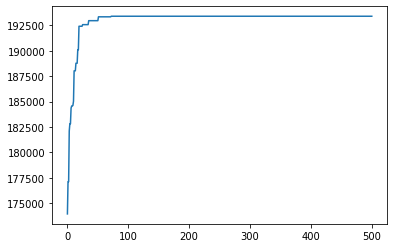

In [216]:
## Hiperparametros del algoritmo genetico
POP_SIZE = 100       # numero de individuos
GENERATIONS = 500   # numero de generaciones
PMUT = 1       # tasa de mutacion

## Inicializa una poblacion inicial de forma aleatoria
population = init_population(POP_SIZE,maxMark=10)

# Evolue la poblacion con el algoritmo genetico (cruzamiento 'onepoint', )
best_ind, bestfitness, history_population = genetic_algorithm(population, marketPool, GENERATIONS, PMUT, crossover="uniform", mutation="flip",select='roulette')

# muestra la evolucion del mejor fitness
plt.plot(bestfitness)
plt.show()

Solución de manera gráfica

In [217]:
m = folium.Map(
    location=[-12.0431805, -77.0282364], zoom_start=13, zoomControl= True, min_zoom=13, max_zoom=13)

[(folium.Marker([marketPool[i].lat, marketPool[i].lon], icon=folium.Icon(color='blue')).add_to(m)) for i in range(len(best_ind.chromosome)) if best_ind.chromosome[i]==1]
[(folium.Marker([marketPool[i].lat, marketPool[i].lon], icon=folium.Icon(color='red')).add_to(m)) for i in range(len(best_ind.chromosome)) if best_ind.chromosome[i]==0]
points = [(marketPool[i].lat, marketPool[i].lon) for i in range(len(best_ind.chromosome)) if best_ind.chromosome[i]==1]
points.append(points[0])
folium.PolyLine(points, color="red", weight=2.5, opacity=1).add_to(m)

m

In [23]:
today = datetime.datetime.now()

def create_geojson_features(df):
    print('> Creating GeoJSON features...')
    history = []
    for index, row in enumerate(df):
      itemHistory = []
      for chromo in range(len(best_ind.chromosome)):
        feature = {
            'type': 'Feature',
            'geometry': {
                'type':'Point', 
                'coordinates':[marketPool[chromo].lon, marketPool[chromo].lat]
            },
            'properties': {
                'time': (today + timedelta(days=index)).__str__(),
                'style': {'color' : 'blue' if row[chromo] == 1 else 'red' },
                'icon': 'circle',
                'iconstyle':{
                    'fillColor': {'color' : 'blue' if row[chromo] == 1 else 'red' },
                    'fillOpacity': 0.8,
                    'stroke': 'true',
                    'radius': 7
                }
            }
        }
        itemHistory.append(feature)
      history.append(itemHistory)
    return history

In [24]:
def make_map(features):
    print('> Making map...')
    coords_lima=[-12.0431805, -77.0282364]
    mapLima = folium.Map(location=coords_lima, zoom_start=13, zoomControl= False, min_zoom=13, max_zoom=13, control_scale=True)

    TimestampedGeoJson(
        {'type': 'FeatureCollection',
        'features': np.array(features).flatten().tolist()}
        , add_last_point=True
        , auto_play=False
        , loop=False
        , max_speed=1
        , loop_button=True
        , date_options='DD'
        , time_slider_drag_update=True
    ).add_to(mapLima)
    
    print('> Done.')
    return mapLima
def plot_solution_map(df):
    features = create_geojson_features(df)
    return make_map(features)

Para revisar la solución de manera mas dinánica se puede ir al archivo **html** generado con nombre **monoSolution.html**

In [25]:
solutionOverTime = plot_solution_map(history_population)
solutionOverTime.save('monoSolution.html')

> Creating GeoJSON features...
> Making map...
> Done.


**n) Experimentación con el algoritmo**

Experimente varias veces el
algoritmo implementado con una población de 100 individuos y 500 generaciones (se
sugiere ejecutar 10 veces) y registre en una tabla los mejores individuos de cada ejecución,
sus fitness y los componentes del fitness desagregados (suma de distancias y suma de
población).

In [26]:
## Hiperparametros del algoritmo genetico
POP_SIZE = 100       # numero de individuos
GENERATIONS = 500   # numero de generaciones
PMUT = 0.1        # tasa de mutacion
individuos,fitness,sum_distancia,sum_poblacion=([] for _ in range(4))
for _ in range(10):
    population = init_population(POP_SIZE,maxMark=10);
    best_ind, bestfitness, _ = genetic_algorithm(population, marketPool, GENERATIONS, PMUT, crossover="uniform", mutation="flip",select='roulette');
    individuos.append(best_ind)
    fitness.append(best_ind.fitness)
    sum_distancia.append(get_fitness_lista(best_ind.chromosome,marketPool)[1])
    sum_poblacion.append(get_fitness_lista(best_ind.chromosome,marketPool)[0])

Poblacion inicial, best_fitness = 177128.10355462044
generacion 0, Mejor fitness = 177128.10355462044)
generacion 10, Mejor fitness = 191705.26685887994)
generacion 20, Mejor fitness = 193248.67046399458)
generacion 30, Mejor fitness = 193409.90950866626)
generacion 40, Mejor fitness = 193409.90950866626)
generacion 50, Mejor fitness = 193409.90950866626)
generacion 60, Mejor fitness = 193409.90950866626)
generacion 70, Mejor fitness = 193409.90950866626)
generacion 80, Mejor fitness = 193409.90950866626)
generacion 90, Mejor fitness = 193409.90950866626)
generacion 100, Mejor fitness = 193409.90950866626)
generacion 110, Mejor fitness = 193409.90950866626)
generacion 120, Mejor fitness = 193409.90950866626)
generacion 130, Mejor fitness = 193409.90950866626)
generacion 140, Mejor fitness = 193409.90950866626)
generacion 150, Mejor fitness = 193409.90950866626)
generacion 160, Mejor fitness = 193409.90950866626)
generacion 170, Mejor fitness = 193409.90950866626)
generacion 180, Mejor 

In [27]:
resultados_mono_obj=pd.DataFrame({'individuos':individuos,'fitness':fitness,'suma_distancia':sum_distancia,'suma_poblacion':sum_poblacion})
resultados_mono_obj

,individuos,fitness,suma_distancia,suma_poblacion
0,<__main__.Individual object at 0x7f46a3f91890>,193409.909509,10309.909509,183100
1,<__main__.Individual object at 0x7f46a4053d10>,193409.909509,10309.909509,183100
2,<__main__.Individual object at 0x7f46a3fc9450>,193409.909509,10309.909509,183100
3,<__main__.Individual object at 0x7f46a3a9af90>,193409.909509,10309.909509,183100
4,<__main__.Individual object at 0x7f46a3f879d0>,193409.909509,10309.909509,183100
5,<__main__.Individual object at 0x7f46a3f369d0>,193409.909509,10309.909509,183100
6,<__main__.Individual object at 0x7f46a3a87110>,193409.909509,10309.909509,183100
7,<__main__.Individual object at 0x7f46a3f36bd0>,193409.909509,10309.909509,183100
8,<__main__.Individual object at 0x7f46a3f91510>,193409.909509,10309.909509,183100
9,<__main__.Individual object at 0x7f46a39f5b90>,193409.909509,10309.909509,183100


## **2) Algoritmo multi-objetivo NSGA-II**

**a) Función para obtener los fitness para los dos objetivos**

In [28]:
def get_fitness_nsga(chromosome, markets):
    fitnesses=np.zeros(2) #cantidad de objetivos a medir
    markets_elegidos=[]
    sum_pob=0
    sum_dist=0
    for i in range(len(markets)):
        if chromosome[i] == 1:  # si el market i esta incluido en el cromosoma, acumula su poblacion y distancia
            sum_pob += markets[i].pob
            markets_elegidos.append(i)
            
    for j in markets_elegidos:
        for k in markets_elegidos[j+1:]:
            sum_dist=sum_dist+lista_total_distancias[(j,k)]
    fitnesses[0]=sum_pob
    fitnesses[1]=sum_dist
    return fitnesses

**b) Funcion para evaluar una población de individuos**

In [29]:
def evaluate_population_nsga(population, markets):
    """ Evalua una poblacion de individuos con la funcion get_fitness """
    pop_size = len(population)
    for i in range(pop_size):
        if population[i].fitness == -1:    # evalua solo si el individuo no esta evaluado
            population[i].fitness = get_fitness_nsga(population[i].chromosome, markets)

**c) Funcion para la obtencion de la poblacion descendiente**

In [30]:
def build_offspring_population(population, crossover, mutation, pmut):     
    """ Construye una poblacion hija con los operadores de cruzamiento y mutacion pasados
        crossover:  operador de cruzamiento
        mutation:   operador de mutacion
        pmut:       taza de mutacion
    """
    pop_size = len(population)
    
    ## Selecciona parejas de individuos (mating_pool) para cruzamiento con el metodo de la ruleta
    mating_pool = []
    for i in range(int(pop_size/2)): 
        # escoge dos individuos diferentes aleatoriamente de la poblacion
        permut = np.random.permutation( pop_size )
        mating_pool.append( (population[permut[0]], population[permut[1]] ) ) 
        
    ## Crea la poblacion descendencia cruzando las parejas del mating pool 
    offspring_population = []
    for i in range(len(mating_pool)): 
        if crossover == "onepoint":
            offspring_population.extend( mating_pool[i][0].crossover_onepoint(mating_pool[i][1]) ) # cruzamiento 1 punto
        elif crossover == "uniform":
            offspring_population.extend( mating_pool[i][0].crossover_uniform(mating_pool[i][1]) ) # cruzamiento uniforme
        else:
            raise NotImplementedError

    ## Aplica el operador de mutacion con probabilidad pmut en cada hijo generado
    for i in range(len(offspring_population)):
        if uniform(0, 1) < pmut: 
            if mutation == "flip":
                offspring_population[i] = offspring_population[i].mutation_flip() # cambia el alelo de un gen
            else:
                raise NotImplementedError   
                
    return offspring_population


**d) Funcion para la obtencion de las distancias crowding**

In [31]:
def get_crowding_distances(fitnesses):
    """
    La distancia crowding de un individuo es la diferencia del fitness mas proximo hacia arriba menos el fitness mas proximo 
    hacia abajo. El valor crowding total es la suma de todas las distancias crowdings para todos los fitness
    """
    #fitnesses de la forma np.array( [ [23,23],[12,21],[2,2] ])
    pop_size = len(fitnesses[:, 0])
    num_objectives = len(fitnesses[0, :])

    # crea matriz crowding. Filas representan individuos, columnas representan objectives
    crowding_matrix = np.zeros((pop_size, num_objectives))

    # normaliza los fitnesses entre 0 y 1 (ptp es max - min)
    # Es importante normalizar los fitness porque pueden venir con diferentes unidades de medida
    normalized_fitnesses = (fitnesses - fitnesses.min(0)) / fitnesses.ptp(0)

    for col in range(num_objectives):   # Por cada objective
        crowding = np.zeros(pop_size)

        # puntos extremos tienen maximo crowding
        crowding[0] = 1
        crowding[pop_size - 1] = 1

        # ordena los fitness normalizados del objectivo actual
        sorted_fitnesses = np.sort(normalized_fitnesses[:, col])
        sorted_fitnesses_index = np.argsort(normalized_fitnesses[:, col])

        # Calcula la distancia crowding de cada individuo como la diferencia de score de los vecinos
        crowding[1:pop_size - 1] = (sorted_fitnesses[2:pop_size] - sorted_fitnesses[0:pop_size - 2])

        # obtiene el ordenamiento original
        re_sort_order = np.argsort(sorted_fitnesses_index)
        sorted_crowding = crowding[re_sort_order]

        # Salva las distancias crowdingpara el objetivo que se esta iterando
        crowding_matrix[:, col] = sorted_crowding

    # Obtiene las distancias crowding finales sumando las distancias crowding de cada objetivo 
    crowding_distances = np.sum(crowding_matrix, axis=1)

    return crowding_distances

**e) Funcion para la seleccion por distancia crowding**

In [32]:
def select_by_crowding(population, num_individuals):
    """
    Selecciona una poblacion de individuos basado en torneos de pares de individuos: dos individuos se escoge al azar
    y se selecciona el mejor segun la distancia crowding. Se repite hasta obtener num_individuals individuos
    """    
    population = deepcopy(population)
    pop_size = len(population)
    num_objectives = len(population[0].fitness)
    
    # extrae los fitness de la poblacion en la matriz fitnesses
    fitnesses = np.zeros([pop_size, num_objectives])
    for i in range(pop_size): fitnesses[i,:] = population[i].fitness
        
    # obtiene las  distancias  crowding
    crowding_distances = get_crowding_distances(fitnesses)   
    
    population_selected = []   # poblacion escogida

    for i in range(num_individuals):  # por cada individuo a seleccionar

        # escoje dos individuos aleatoriamente de la poblacion no escogida aun
        permut = np.random.permutation( len(population) )
        ind1_id = permut[0]
        ind2_id = permut[1]

        # Si ind1_id es el mejor
        if crowding_distances[ind1_id] >= crowding_distances[ind2_id]:

            # traslada el individuo ind1 de population a la lista de individuos seleccionados
            population_selected.append( population.pop(ind1_id) )
            # remueve la distancia crowding del individuo seleccionado
            crowding_distances = np.delete(crowding_distances, ind1_id, axis=0)
            
        else:  # Si ind2_id es el mejor
            
            # traslada el individuo ind2 de population a la lista de individuos seleccionados
            population_selected.append( population.pop(ind2_id) )
            # remueve la distancia crowding del individuo seleccionado
            crowding_distances = np.delete(crowding_distances, ind2_id, axis=0)

    return (population_selected)

**f) Funcion para de la frontera de pareto**

In [33]:
def get_paretofront_population(population):
    """
    Obtiene de population la poblacion de individups de la frontera de Pareto, 
    """
    population = deepcopy(population)
    pop_size = len(population)
    
    # todos los individuos son inicialmente asumidos como la frontera de Pareto
    pareto_front = np.ones(pop_size, dtype=bool)
    
    for i in range(pop_size): # Compara cada individuo contra todos los demas
        for j in range(pop_size):
            # Chequea si individuo 'i' es dominado por individuo 'j'
            if all(population[j].fitness >= population[i].fitness) and any(population[j].fitness > population[i].fitness): #NO es OR ?
                # j domina i -> señaliza que individuo 'i' como no siendo parte de la frontera de Pareto
                pareto_front[i] = 0
                break   # Para la busqueda para 'i' (no es necesario hacer mas comparaciones)

    paretofront_population = []
    for i in range(pop_size):  # construye la lista de individuos de la frontera de Pareto 
        if pareto_front[i] == 1: paretofront_population.append(population[i])
        
    return paretofront_population

**g) Funcion para la obtencion de la siguiente poblacion**

In [34]:
def build_next_population(population, min_pop_size, max_pop_size):
    """
    Construye la poblacion de la siguiente generacion añadiendo sucesivas fronteras de Pareto hasta 
    tener una poblacion de al menos min_pop_size individuos. Reduce la frontera de Pareto con el metodo de
    crowding distance si al agregar la frontera excede el tamaño maximo de la poblacion (max_pop_size)
    """
    population = deepcopy(population)
    pareto_front = []
    next_population = []
    
    while len(next_population) < min_pop_size:   # mientras la poblacion no tenga el tamaño minimo
        # obtiene la poblacion frontera de Pareto actual
        paretofront_population = get_paretofront_population(population)
        
        # si poblacion actual + paretofront excede el maximo permitido -> reduce paretofront con el metodo de crowding
        combined_population_size = len(next_population) + len(paretofront_population)
        if  combined_population_size > max_pop_size:
            paretofront_population = select_by_crowding( paretofront_population, max_pop_size-len(next_population) ) 
        
        # Adiciona la frontera de Pareto (original o reducida) a la poblacion en construccion
        next_population.extend( paretofront_population )
    
        # remueve de population los individuos que fueron agregados a next_population 
        for i in range( len(paretofront_population) ):
            for j in range( len(population) ):
                if all( np.asarray(paretofront_population[i].chromosome) == np.asarray(population[j].chromosome) ):
                    del(population[j])
                    break
                    
    return next_population

**h) Ejecucion del algoritmo**

In [35]:
## Hiperparametros del algoritmo genetico
POP_SIZE = 50       # numero de individuos
GENERATIONS = 500   # numero de generaciones
PMUT = 1        # taza de mutacion
MIN_POP_SIZE = 100    # numero de individuos minimo
MAX_POP_SIZE = 100    # numero de individuos maximo

## Inicializa una poblacion inicial de forma aleatoria
P = init_population(POP_SIZE,maxMark=10)

evaluate_population_nsga(P,marketPool)    #  evalua la poblacion inicial
## Ejecuta los ciclos evolutivos 
for g in range(GENERATIONS):   # Por cada generacion
    
    if g %10 == 0:
        print ('Generacion {} (de {}) '.format(g, GENERATIONS))
    
    ## genera y evalua la poblacion hija    
    Q = build_offspring_population(P, "uniform", "flip", PMUT)
    evaluate_population_nsga(Q, marketPool)
    
    ## une la poblacion padre y la poblacion hija
    P.extend(Q) 
    
    ## Construye la poblacion de la siguiente generacion
    P = build_next_population(P, MIN_POP_SIZE, MAX_POP_SIZE)

# Obtiene la poblacion de la frontera de pareto final 
pareto_front_population = get_paretofront_population(P)

Generacion 0 (de 500) 
Generacion 10 (de 500) 
Generacion 20 (de 500) 
Generacion 30 (de 500) 
Generacion 40 (de 500) 
Generacion 50 (de 500) 
Generacion 60 (de 500) 
Generacion 70 (de 500) 
Generacion 80 (de 500) 
Generacion 90 (de 500) 
Generacion 100 (de 500) 
Generacion 110 (de 500) 
Generacion 120 (de 500) 
Generacion 130 (de 500) 
Generacion 140 (de 500) 
Generacion 150 (de 500) 
Generacion 160 (de 500) 
Generacion 170 (de 500) 
Generacion 180 (de 500) 
Generacion 190 (de 500) 
Generacion 200 (de 500) 
Generacion 210 (de 500) 
Generacion 220 (de 500) 
Generacion 230 (de 500) 
Generacion 240 (de 500) 
Generacion 250 (de 500) 
Generacion 260 (de 500) 
Generacion 270 (de 500) 
Generacion 280 (de 500) 
Generacion 290 (de 500) 
Generacion 300 (de 500) 
Generacion 310 (de 500) 
Generacion 320 (de 500) 
Generacion 330 (de 500) 
Generacion 340 (de 500) 
Generacion 350 (de 500) 
Generacion 360 (de 500) 
Generacion 370 (de 500) 
Generacion 380 (de 500) 
Generacion 390 (de 500) 
Generacion 

**i) Visualizacion de la frontera de pareto**

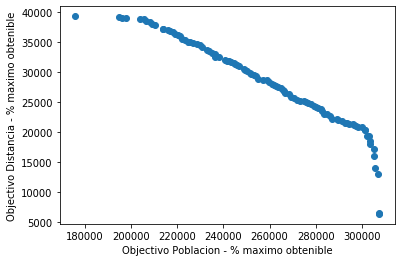

In [36]:
## Plotea los individuos de la frontera de Pareto final
CHROMOSOME_SIZE = 60 
pop_size = len(pareto_front_population)
num_objectives = len(pareto_front_population[0].fitness)
    
# extrae los fitness de la poblacion en la matriz fitnesses
fitnesses = np.zeros([pop_size, num_objectives])
for i in range(pop_size): fitnesses[i,:] = pareto_front_population[i].fitness

x = fitnesses[:, 0]/CHROMOSOME_SIZE*100
y = fitnesses[:, 1]/CHROMOSOME_SIZE*100
plt.xlabel('Objectivo Poblacion - % maximo obtenible') #Primer objetivo: Maximizar el valor de la mochila
plt.ylabel('Objectivo Distancia - % maximo obtenible') #Segundo objetivo: Minimizar el peso de la mochila
plt.scatter(x,y)
#plt.savefig('pareto.png')
plt.show()


**Verificacion si la solucion que nos otorgó el mono objetivo es parte de las soluciones obtenidas por NSGA-II**

In [37]:
cromosomas=[indi.chromosome for indi in pareto_front_population]
valor=True if best_ind.chromosome in cromosomas else False
valor

True

Vemos que la primera solución de pareto optimiza a los lugares que poseen una mayor distancia entre ellos, esto se observa en el gráfico

In [38]:
m = folium.Map(
    location=[-12.0431805, -77.0282364], zoom_start=13, zoomControl= False, min_zoom=13, max_zoom=13)

[(folium.Marker([marketPool[i].lat, marketPool[i].lon], icon=folium.Icon(color='red')).add_to(m)) for i in range(len(pareto_front_population[0].chromosome)) if pareto_front_population[0].chromosome[i]==0]
[(folium.Marker([marketPool[i].lat, marketPool[i].lon], icon=folium.Icon(color='blue')).add_to(m)) for i in range(len(pareto_front_population[0].chromosome)) if pareto_front_population[0].chromosome[i]==1]
points = [(marketPool[i].lat, marketPool[i].lon) for i in range(len(pareto_front_population[0].chromosome)) if pareto_front_population[0].chromosome[i]==1]
points.append(points[0])
folium.PolyLine(points, color="red", weight=2.5, opacity=1).add_to(m)

m

In [39]:
print("Esta solución tiene como cantidad de población {} y un maximo de distancia de entre locales de {}".format(pareto_front_population[0].fitness[0], pareto_front_population[0].fitness[1]))

Esta solución tiene como cantidad de población 144350.0 y un maximo de distancia de entre locales de 19241.804127280077


Ahora probaremos con la frontera de parto que intenta maximizar la distancia entre las ciudades y la población. Este valor estaba ubicado aproximadamente en la mitad

In [40]:
indexMid = int(round(len(pareto_front_population)/2, 0))
m = folium.Map(
    location=[-12.0431805, -77.0282364], zoom_start=13, zoomControl= False, min_zoom=13, max_zoom=13)

[(folium.Marker([marketPool[i].lat, marketPool[i].lon], icon=folium.Icon(color='red')).add_to(m)) for i in range(len(pareto_front_population[indexMid].chromosome)) if pareto_front_population[indexMid].chromosome[i]==0]
[(folium.Marker([marketPool[i].lat, marketPool[i].lon], icon=folium.Icon(color='blue')).add_to(m)) for i in range(len(pareto_front_population[indexMid].chromosome)) if pareto_front_population[indexMid].chromosome[i]==1]
points = [(marketPool[i].lat, marketPool[i].lon) for i in range(len(pareto_front_population[indexMid].chromosome)) if pareto_front_population[indexMid].chromosome[i]==1]
points.append(points[0])
folium.PolyLine(points, color="red", weight=2.5, opacity=1).add_to(m)

m

In [41]:
print("Esta solución tiene como cantidad de población {} y un maximo de distancia de entre locales de {}".format(pareto_front_population[indexMid].fitness[0], pareto_front_population[indexMid].fitness[1]))

Esta solución tiene como cantidad de población 167600.0 y un maximo de distancia de entre locales de 14599.491380601108


**j) Experimentación con el algoritmo**

Experimente varias
veces el algoritmo implementado con una población de 100 individuos y 500 generaciones
(se sugiere ejecutar 10 veces). En cada ejecución registre los individuos de la frontera de
Pareto final, así como los valores de las funciones objetivos de dichos individuo. Realice
Plots de las fronteras de Pareto encontradas, ubicando en dichos plots los puntos de los
mejores individuos encontrados con el algoritmo mono-objetivo.

In [42]:
## Hiperparametros del algoritmo genetico
POP_SIZE = 100       # numero de individuos
GENERATIONS = 500   # numero de generaciones
PMUT = 1       # tasa de mutacion, influye en el resultado
MIN_POP_SIZE = 100    # numero de individuos minimo
MAX_POP_SIZE = 100    # numero de individuos maximo

num_iteracion,individuos_pareto,obj_pob,obj_dist=([] for _ in range(4))
for i in range(10):
    
    ## Inicializa una poblacion inicial de forma aleatoria
    P = init_population(POP_SIZE,maxMark=10)

    evaluate_population_nsga(P,marketPool)    #  evalua la poblacion inicial
    print(f'Iteracion {i+1}')
    ## Ejecuta los ciclos evolutivos 
    for g in range(GENERATIONS):   # Por cada generacion
        if g %10 == 0:
            print ('Generacion {} (de {}) '.format(g, GENERATIONS))

        ## genera y evalua la poblacion hija    
        Q = build_offspring_population(P, "uniform", "flip", PMUT)
        evaluate_population_nsga(Q, marketPool)

        ## une la poblacion padre y la poblacion hija
        P.extend(Q) 

        ## Construye la poblacion de la siguiente generacion
        P = build_next_population(P, MIN_POP_SIZE, MAX_POP_SIZE)

    # Obtiene la poblacion de la frontera de pareto final 
    pareto_front_population = get_paretofront_population(P) 
    
    num_iteracion.append([i for _ in range(len(pareto_front_population)) ]) #Almacenamos el numero de iteracion para distingirlos en el dataframe
    individuos_pareto.append(pareto_front_population) #Almacenamos los individuos que se encuentran en la frontera de pareto
    obj_pob.append([individuo.fitness[0] for individuo in pareto_front_population]) #Almacenamos el objetivo poblacion de cada individuo
    obj_dist.append([individuo.fitness[1] for individuo in pareto_front_population]) #Almacenamos el objetivo distancia de cada individuo

Iteracion 1
Generacion 0 (de 500) 
Generacion 10 (de 500) 
Generacion 20 (de 500) 
Generacion 30 (de 500) 
Generacion 40 (de 500) 
Generacion 50 (de 500) 
Generacion 60 (de 500) 
Generacion 70 (de 500) 
Generacion 80 (de 500) 
Generacion 90 (de 500) 
Generacion 100 (de 500) 
Generacion 110 (de 500) 
Generacion 120 (de 500) 
Generacion 130 (de 500) 
Generacion 140 (de 500) 
Generacion 150 (de 500) 
Generacion 160 (de 500) 
Generacion 170 (de 500) 
Generacion 180 (de 500) 
Generacion 190 (de 500) 
Generacion 200 (de 500) 
Generacion 210 (de 500) 
Generacion 220 (de 500) 
Generacion 230 (de 500) 
Generacion 240 (de 500) 
Generacion 250 (de 500) 
Generacion 260 (de 500) 
Generacion 270 (de 500) 
Generacion 280 (de 500) 
Generacion 290 (de 500) 
Generacion 300 (de 500) 
Generacion 310 (de 500) 
Generacion 320 (de 500) 
Generacion 330 (de 500) 
Generacion 340 (de 500) 
Generacion 350 (de 500) 
Generacion 360 (de 500) 
Generacion 370 (de 500) 
Generacion 380 (de 500) 
Generacion 390 (de 500) 

Flatten para cada lista

In [43]:
num_iteracion=[item for sublist in num_iteracion for item in sublist]
individuos_pareto=[item for sublist in individuos_pareto for item in sublist]
obj_pob=[item for sublist in obj_pob for item in sublist]
obj_dist=[item for sublist in obj_dist for item in sublist]

In [44]:
resultados_multi_obj=pd.DataFrame({'numero_iteracion':num_iteracion,'individuos_pareto':individuos_pareto,
                                   'objetivo_poblacion':obj_pob,'objetivo_distancia':obj_dist})
resultados_multi_obj

,numero_iteracion,individuos_pareto,objetivo_poblacion,objetivo_distancia
0,0,<__main__.Individual object at 0x7f46a3a27090>,180650.0,12185.885870
1,0,<__main__.Individual object at 0x7f46a39fc410>,162550.0,15359.669046
2,0,<__main__.Individual object at 0x7f46a4d61b50>,124750.0,23042.818309
3,0,<__main__.Individual object at 0x7f46a4d61a10>,161250.0,15715.609747
4,0,<__main__.Individual object at 0x7f46a34ffc50>,170650.0,13810.740079
...,...,...,...,...
995,9,<__main__.Individual object at 0x7f46a3c5af10>,180450.0,12271.870977
996,9,<__main__.Individual object at 0x7f46a3c5a450>,152550.0,17569.430740
997,9,<__main__.Individual object at 0x7f46a3c5a0d0>,149650.0,18206.266223
998,9,<__main__.Individual object at 0x7f46a3b1bd90>,161650.0,15491.882835


**k) Plots de las fronteras de pareto**

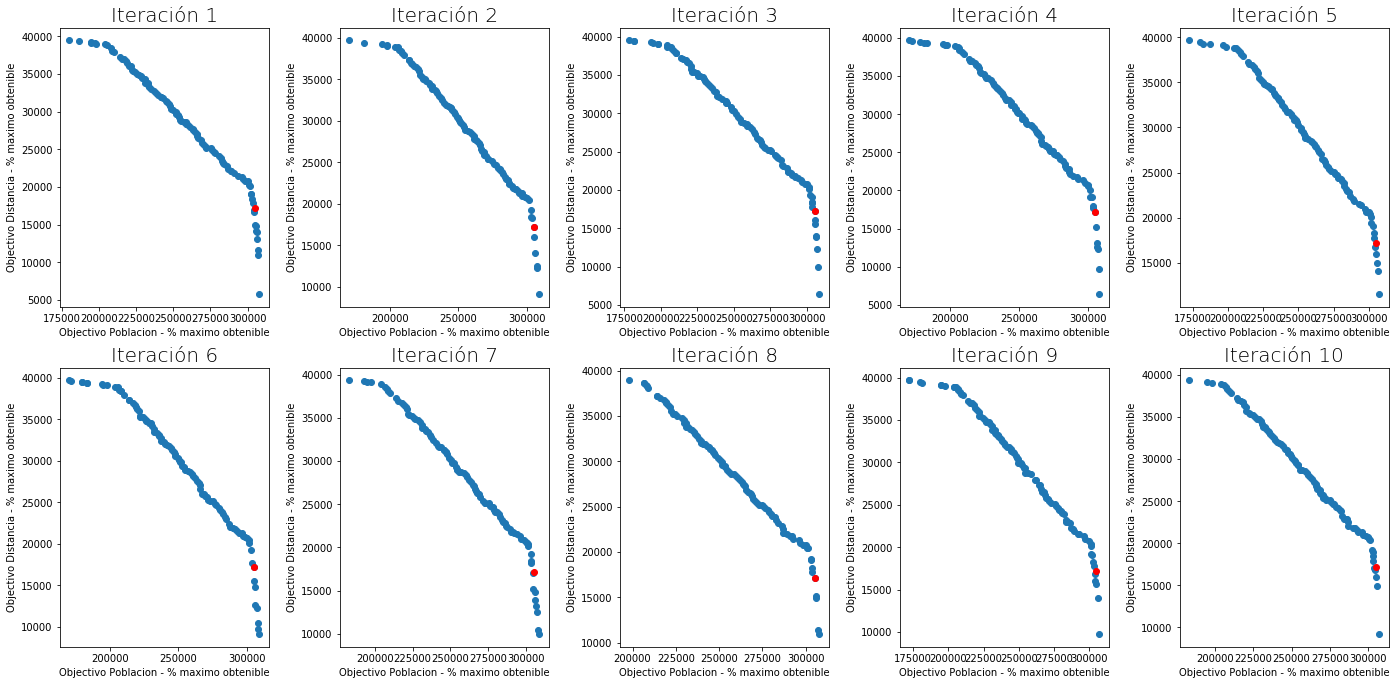

In [45]:
fig,axes=plt.subplots(nrows=2, ncols=5,figsize=(20,10))
fig.tight_layout(pad=4)
for i in range(10):
    subplot=plt.subplot(2,5, i+1)    
    plt.title(f'Iteración {i+1}', loc='center', fontsize=20, fontweight=0)
    fitnesses = np.zeros([pop_size, num_objectives])
    for j in range(pop_size): fitnesses[j,:] = resultados_multi_obj.individuos_pareto[resultados_multi_obj.numero_iteracion == i].iloc[j].fitness
    x = fitnesses[:, 0]/CHROMOSOME_SIZE*100
    y = fitnesses[:, 1]/CHROMOSOME_SIZE*100
    plt.xlabel('Objectivo Poblacion - % maximo obtenible') #Primer objetivo: Maximizar el valor de la mochila
    plt.ylabel('Objectivo Distancia - % maximo obtenible') #Segundo objetivo: Minimizar el peso de la mochila
    plt.scatter(x,y)
    #Plot de los mejores individuos encontrados con el algoritmo mono objetivo
    x_multi=resultados_mono_obj.iloc[i].suma_poblacion/CHROMOSOME_SIZE*100
    y_multi=resultados_mono_obj.iloc[i].suma_distancia/CHROMOSOME_SIZE*100
    plt.scatter(x_multi,y_multi,c='red')